<a id="1"></a>
# Including Libraries

Install some libraries if necessary and import everything that is needed

In [39]:
# !pip install librosa 

In [135]:
# Display graphs in line
%matplotlib inline

# Import Functions
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np 
np.random.seed(42)

import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
from tqdm import tqdm # install ipywidgets to address warning

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import os
import random

# Suppress read write warnings
import warnings
warnings.filterwarnings('ignore')

#Set the Device to do training on
device = "cuda" if torch.cuda.is_available() else "cpu"

<a id="2"></a>
# Including the Datasets

A path needs to be provided to the main directory. Inside this directory should be a list of folders with Emotions. Each folder contains the audio files ot load

In [41]:
import pandas as pd
import numpy as np
import os
Crema_Path='data/Crema/'
Ravdess_Path='data/Ravdess/audio_speech_actors_01-24'
Savee_Path='data/Savee/' 
Tess_Path='data/Tess/'

class DataSetLoader:
    def __init__(self,data_set_name='All'):
        self.data_set_name = data_set_name
        self.selected_data_set = None
        if self.data_set_name == 'Crema':
            self.selected_data_set = Crema()
        elif self.data_set_name == 'Ravdess':
            self.selected_data_set = Ravdess()
        elif self.data_set_name == 'Savee':
            self.selected_data_set = Savee()
        elif self.data_set_name == 'Tess':
            self.selected_data_set = Tess()
        
        
    def load_data(self):
        if self.data_set_name == 'All':
            crema = Crema()
            ravdess = Ravdess()
            savee = Savee()
            tess = Tess()
            crema_df = crema.load_data()
            ravdess_df = ravdess.load_data()
            savee_df = savee.load_data()
            tess_df = tess.load_data()
            data_set = pd.concat([crema_df,ravdess_df,savee_df,tess_df],ignore_index=True)
            return data_set
        else:
            return self.selected_data_set.load_data()
    
    def get_data_set_name(self):
        return self.data_set_name

class Crema:
    def load_data(self):
        crema=[]
        for wav in os.listdir(Crema_Path):
            emotion=wav.partition(".wav")[0].split('_')
            if emotion[2]=='SAD':
                crema.append(('Sad',Crema_Path+wav))
            elif emotion[2]=='ANG':
                crema.append(('Angry',Crema_Path+wav))
            elif emotion[2]=='DIS':
                crema.append(('Disgust',Crema_Path+wav))
            elif emotion[2]=='FEA':
                crema.append(('Fear',Crema_Path+wav))
            elif emotion[2]=='HAP':
                crema.append(('Happy',Crema_Path+wav))
            elif emotion[2]=='NEU':
                crema.append(('Neutral',Crema_Path+wav))
            else:
                crema.append(('unknown',Crema_Path+wav))
        Crema_df=pd.DataFrame.from_dict(crema)
        Crema_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Crema_df['Emotion'].unique()
        return Crema_df
    
class Ravdess:
    def load_data(self):
        ravdess=[]
        for directory in os.listdir(Ravdess_Path):
            actors=os.listdir(os.path.join(Ravdess_Path,directory))
            for wav in actors:
                emotion=wav.partition('.wav')[0].split('-')
                emotion_number=int(emotion[2])
                ravdess.append((emotion_number,os.path.join(Ravdess_Path,directory,wav)))
        Ravdess_df=pd.DataFrame.from_dict(ravdess)
        Ravdess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Ravdess_df['Emotion'].replace({1:'Neutral', 2:'Neutral', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fear', 7:'Disgust', 8:'Surprise'},inplace=True)
        Ravdess_df.head()
        Ravdess_df['Emotion'].unique()
        return Ravdess_df


class Savee:
    def load_data(self):
        import re
        savee=[]
        for wav in os.listdir(Savee_Path):
            emo=wav.partition('.wav')[0].split('_')[1].replace(r'[0-9]','')
            emotion=re.split(r'[0-9]',emo)[0]
            if emotion=='a':
                savee.append(('Angry',Savee_Path+'/'+wav))
            elif emotion=='d':
                savee.append(('Disgust',Savee_Path+'/'+wav))
            elif emotion=='f':
                savee.append(('Fear',Savee_Path+'/'+wav))
            elif emotion=='h':
                savee.append(('Happy',Savee_Path+'/'+wav))
            elif emotion=='n':
                savee.append(('Neutral',Savee_Path+'/'+wav))
            elif emotion=='sa':
                savee.append(('Sad',Savee_Path+'/'+wav))
            elif emotion=='su':
                savee.append(('Surprise',Savee_Path+'/'+wav))
        Savee_df=pd.DataFrame.from_dict(savee)
        Savee_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Savee_df.head()
        Savee_df['Emotion'].unique()
        return Savee_df

class Tess:
    def load_data(self):
        tess=[]
        for directory in os.listdir(Tess_Path):
            for wav in os.listdir(os.path.join(Tess_Path,directory)):
                emotion=wav.partition('.wav')[0].split('_')
                if emotion[2]=='ps':
                    tess.append(('Surprise',os.path.join(Tess_Path,directory,wav)))
                else:
                    tess.append((emotion[2],os.path.join(Tess_Path,directory,wav)))
        Tess_df=pd.DataFrame.from_dict(tess)
        Tess_df.rename(columns={0:'Emotion',1:'File_Path'},inplace=True)
        Tess_df['Emotion'] = Tess_df['Emotion'].apply(str.title)
        Tess_df.head()
        return Tess_df

<a id="3"></a>
# Data Analyze

In [42]:
# Convert the dataframe to a csv so it doesn't need to be recreated every time
main_path='main_df.csv'
main_df=DataSetLoader('All').load_data()
main_df.to_csv(main_path,index=False)

In [43]:
main_df.head(15)

,Emotion,File_Path
0,Disgust,data/Crema/1001_DFA_DIS_XX.wav
1,Fear,data/Crema/1001_DFA_FEA_XX.wav
2,Happy,data/Crema/1001_DFA_HAP_XX.wav
3,Neutral,data/Crema/1001_DFA_NEU_XX.wav
4,Sad,data/Crema/1001_DFA_SAD_XX.wav
5,Angry,data/Crema/1001_IEO_ANG_HI.wav
6,Angry,data/Crema/1001_IEO_ANG_LO.wav
7,Angry,data/Crema/1001_IEO_ANG_MD.wav
8,Disgust,data/Crema/1001_IEO_DIS_HI.wav
9,Disgust,data/Crema/1001_IEO_DIS_LO.wav


In [44]:
main_df.tail(15)

,Emotion,File_Path
12146,Sad,data/Tess/YAF_Sad\YAF_walk_sad.wav
12147,Sad,data/Tess/YAF_Sad\YAF_wash_sad.wav
12148,Sad,data/Tess/YAF_Sad\YAF_week_sad.wav
12149,Sad,data/Tess/YAF_Sad\YAF_wheat_sad.wav
12150,Sad,data/Tess/YAF_Sad\YAF_when_sad.wav
12151,Sad,data/Tess/YAF_Sad\YAF_which_sad.wav
12152,Sad,data/Tess/YAF_Sad\YAF_whip_sad.wav
12153,Sad,data/Tess/YAF_Sad\YAF_white_sad.wav
12154,Sad,data/Tess/YAF_Sad\YAF_wife_sad.wav
12155,Sad,data/Tess/YAF_Sad\YAF_wire_sad.wav


In [45]:
emotion_names=main_df['Emotion'].unique()

In [46]:
# Setup variable for further displays
emotion_names=main_df['Emotion'].unique()
colors={'Disgust':'#804E2D','Happy':'#F19C0E','Sad':'#478FB8','Neutral':'#4CB847','Fear':'#7D55AA','Angry':'#C00808','Surprise':'#EE00FF'}


#### Evaluate Distribution

Plot a histogram of the labels. The data is relatively balanced but the surprised class is lacking. We will fix that later during augmentation after loading the audio from the files

[Text(0, 0, 'Disgust'),
 Text(1, 0, 'Fear'),
 Text(2, 0, 'Happy'),
 Text(3, 0, 'Neutral'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Angry'),
 Text(6, 0, 'Surprise')]

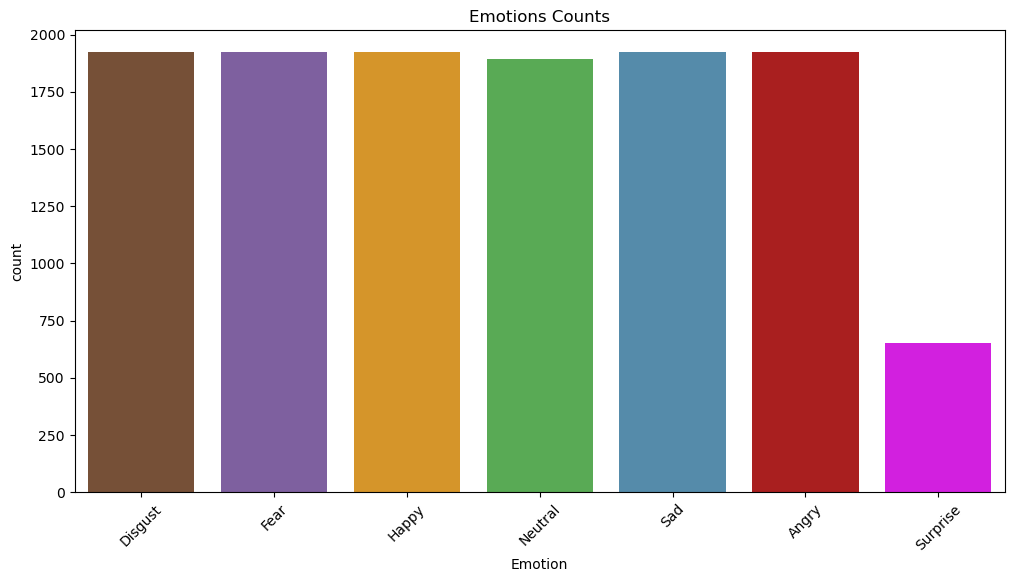

In [47]:
# Evaluate the distribution of the data
plt.figure(figsize=(12,6))
plt.title('Emotions Counts')
emotions=sns.countplot(x='Emotion',data=main_df,palette=colors)
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)

In [48]:
#Make helper functions to display audio files
def wave_plot(data,sr,emotion,color):
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for waveplot',size=17)
    librosa.display.waveshow(y=data,sr=sr,color=color)

def spectogram(data,sr,emotion):
    audio=librosa.stft(data)
    audio_db=librosa.amplitude_to_db(abs(audio))
    plt.figure(figsize=(12,5))
    plt.title(f'{emotion} emotion for spectrogram',size=17)
    librosa.display.specshow(audio_db,sr=sr,x_axis='time',y_axis='hz')

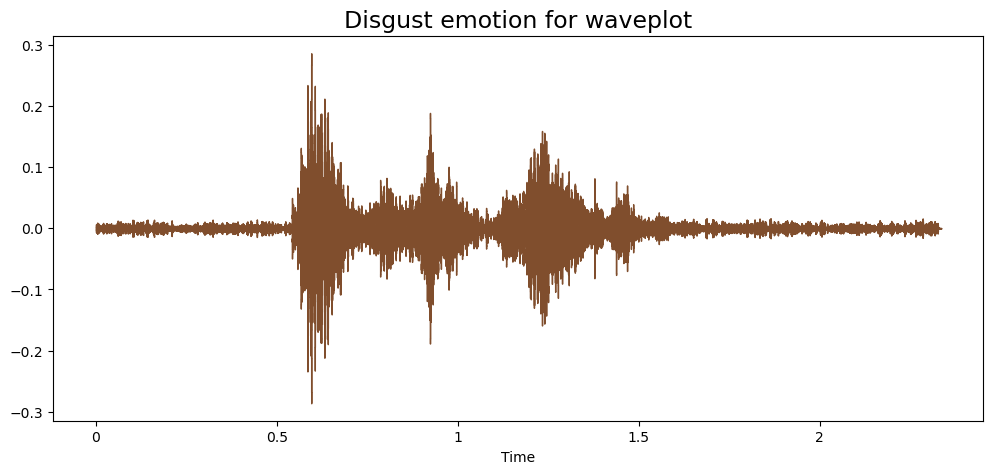

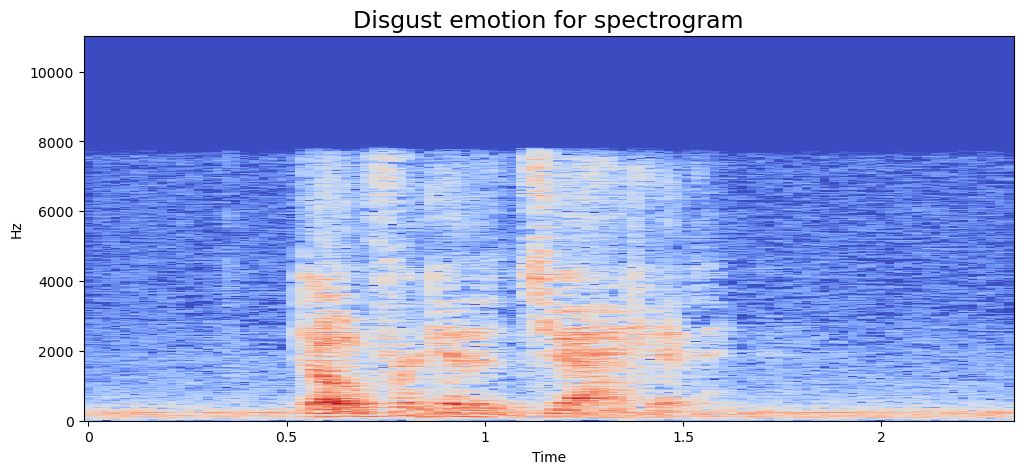

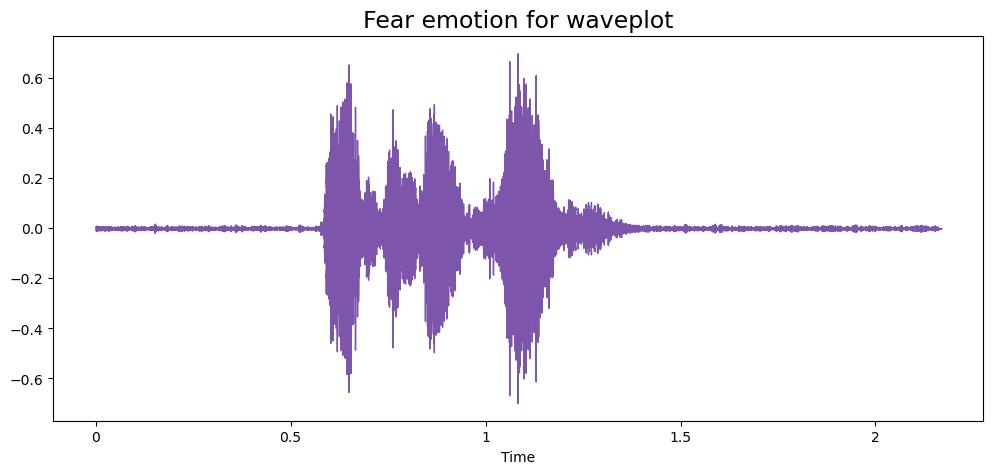

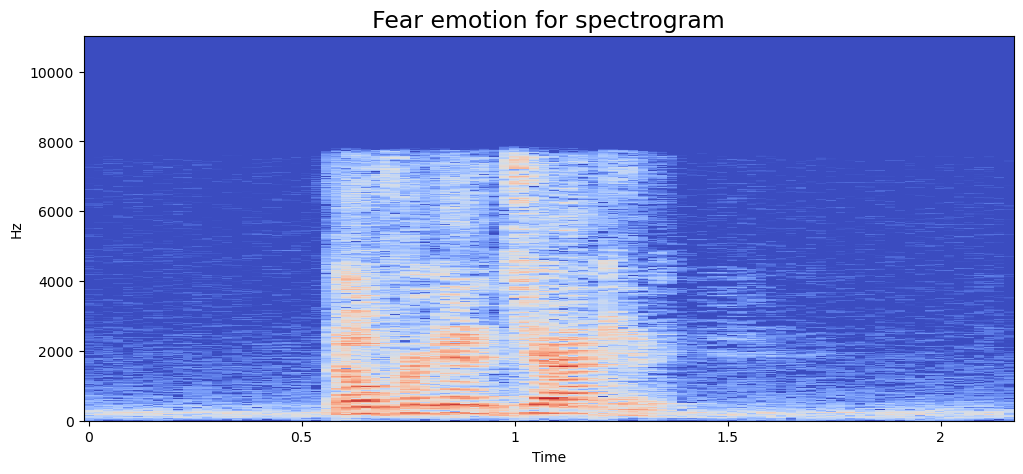

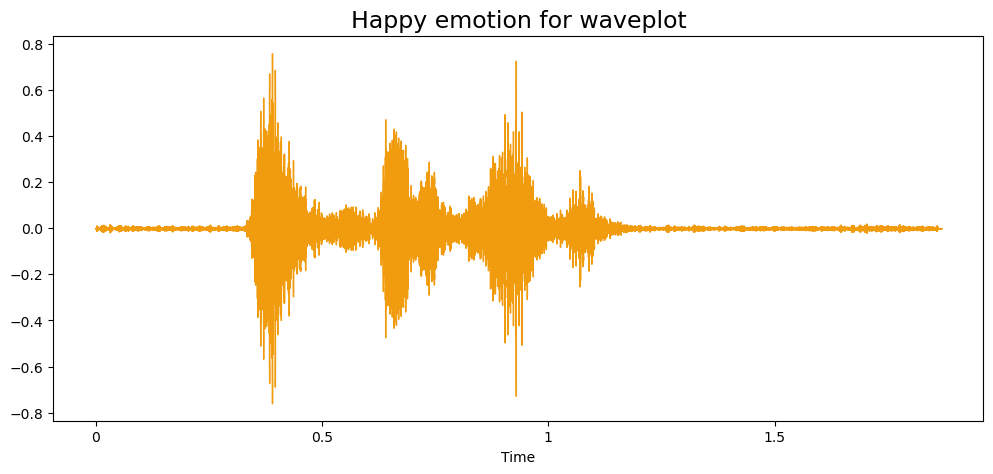

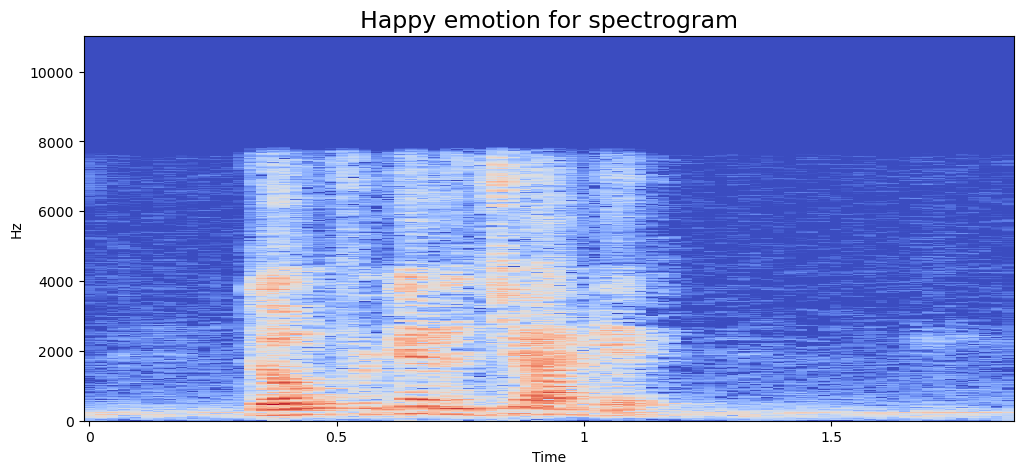

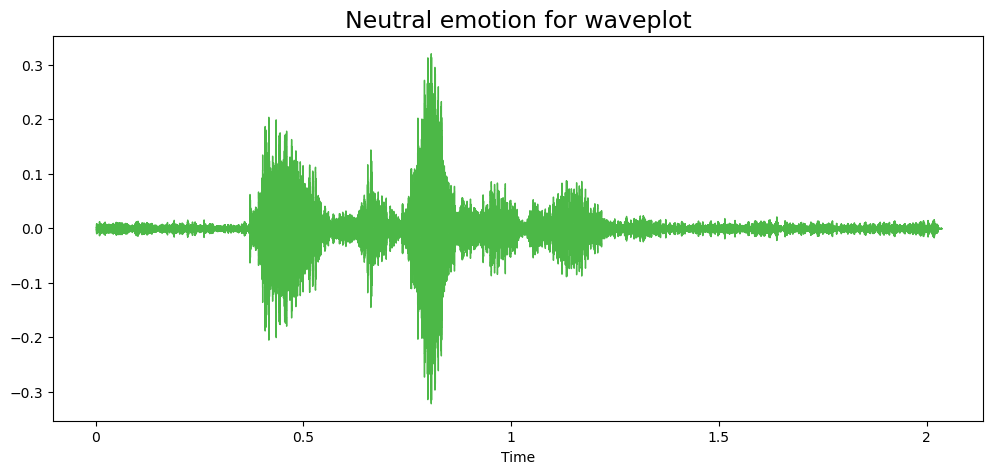

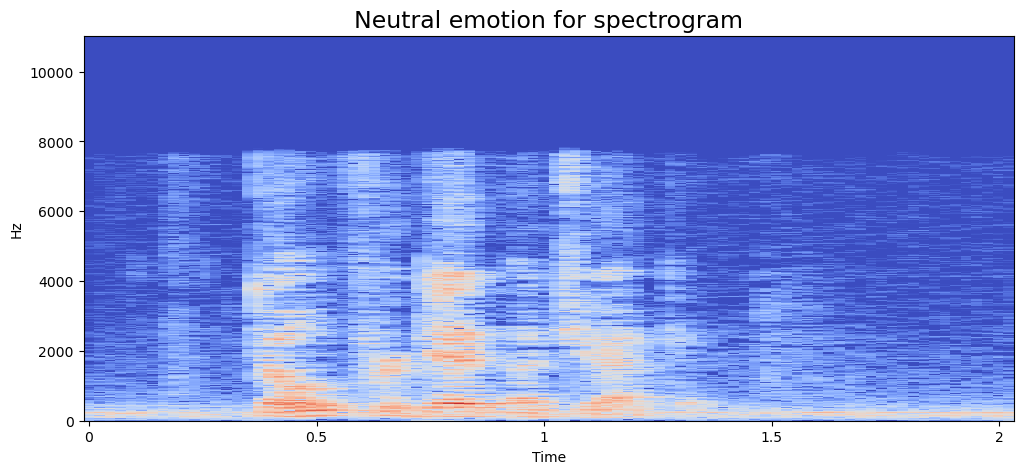

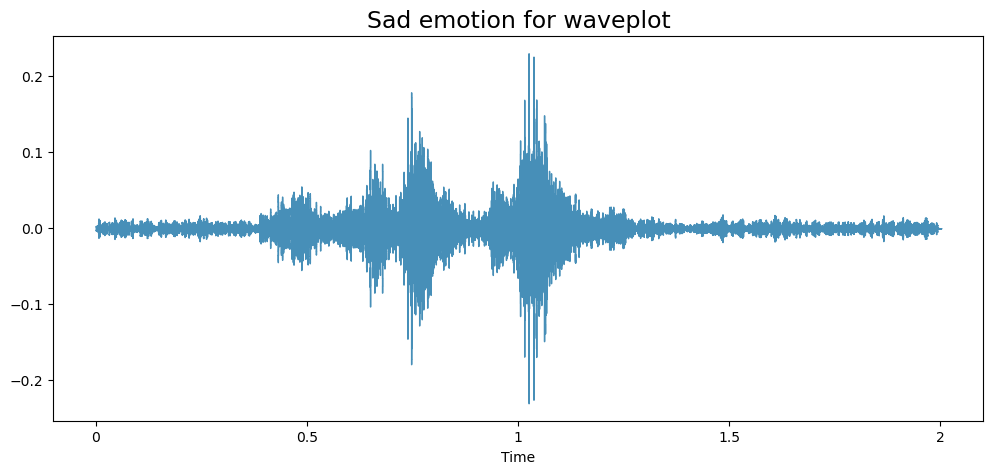

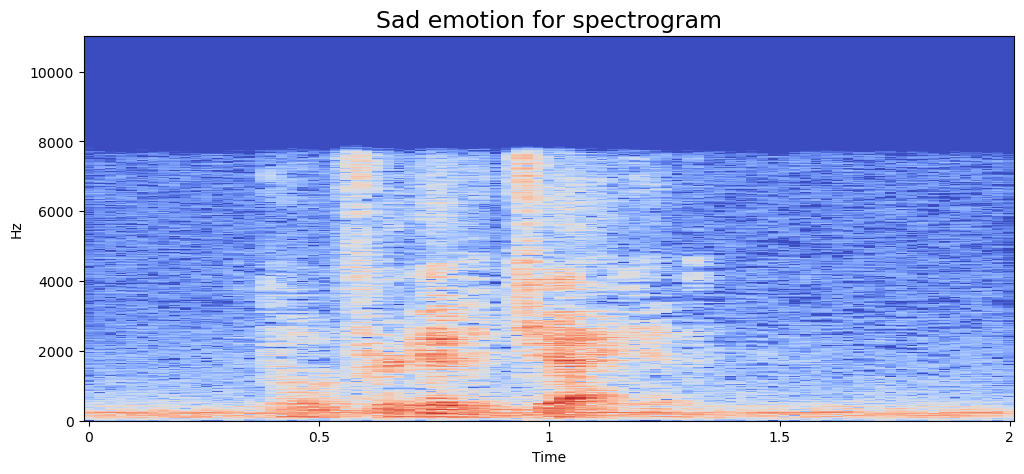

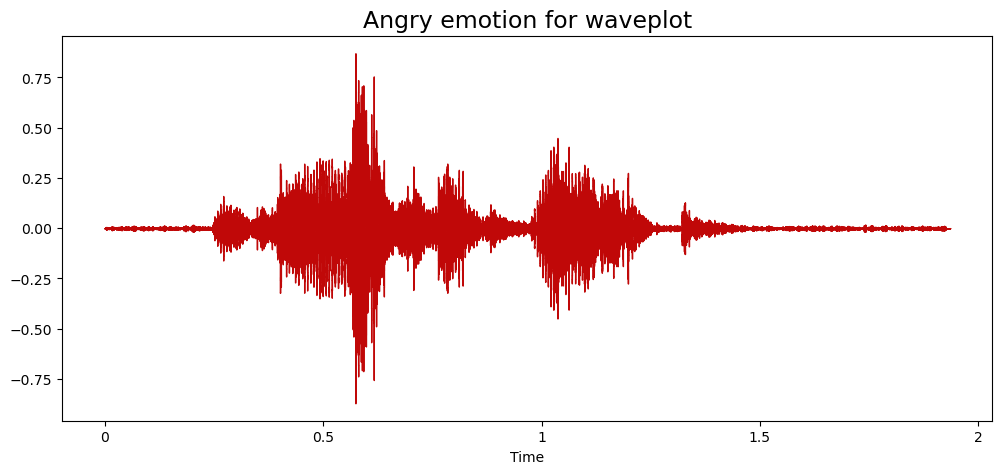

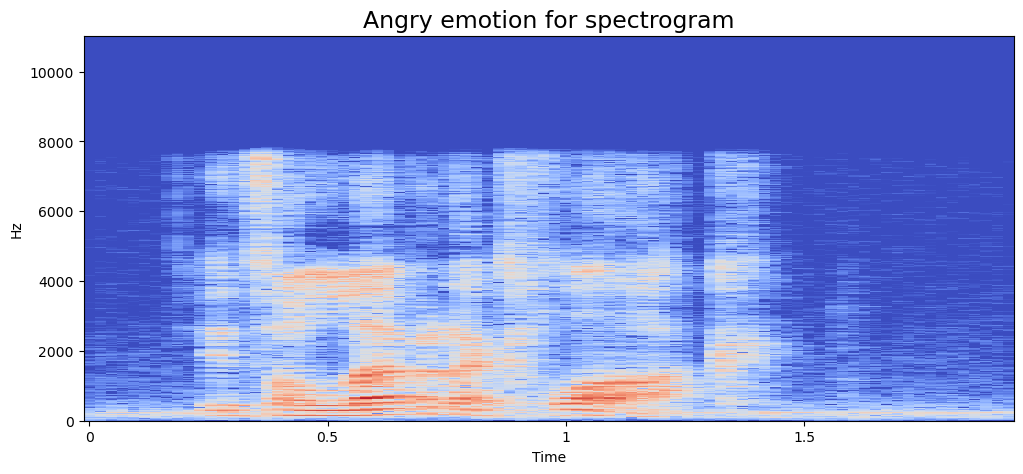

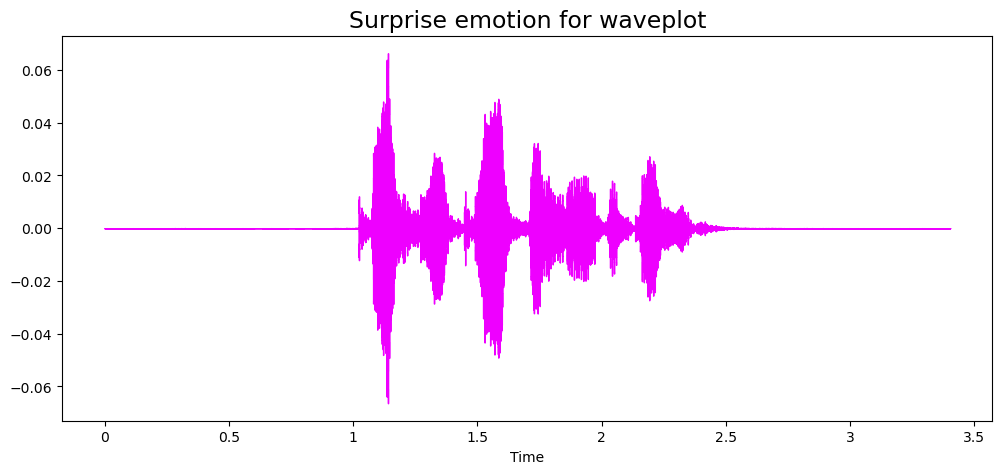

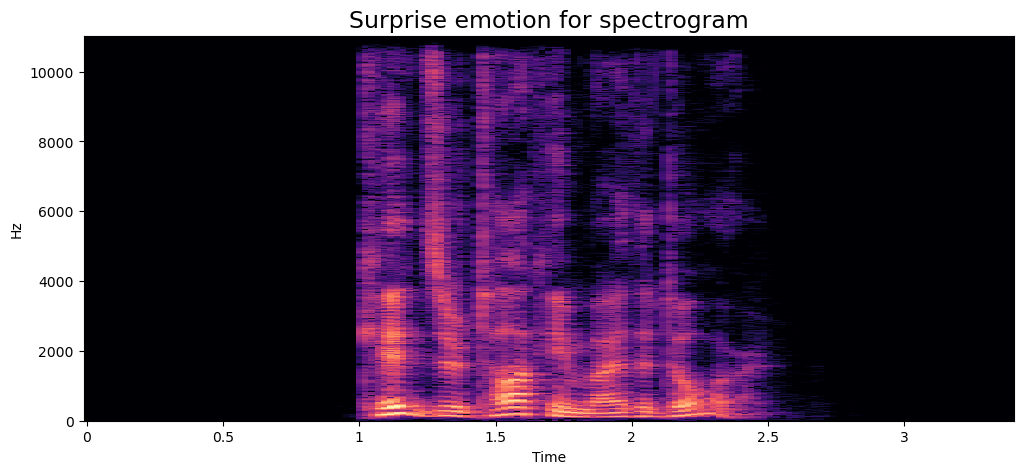

In [49]:
# Take a path from each emotion and display the wave form and spectrogram
audio_path={}
for emotion in emotion_names:
    path=main_df[main_df['Emotion']==emotion]['File_Path'].iloc[0]
    audio_path[emotion]=path

for emotion,path in audio_path.items():
    data,sr=librosa.load(path)
    wave_plot(data,sr,emotion,colors[emotion])
    spectogram(data,sr,emotion)

# Create a function to extract features from the audio files

Setup cells to listen to the samples of audio files

In [50]:
emotion_type = 'Happy'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

data/Crema/1001_DFA_HAP_XX.wav
Happy Audio Sample:  data/Crema/1001_DFA_HAP_XX.wav


In [51]:
emotion_type = 'Sad'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

data/Crema/1001_DFA_SAD_XX.wav
Sad Audio Sample:  data/Crema/1001_DFA_SAD_XX.wav


In [52]:
emotion_type = 'Fear'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

data/Crema/1001_DFA_FEA_XX.wav
Fear Audio Sample:  data/Crema/1001_DFA_FEA_XX.wav


In [53]:
emotion_type = 'Neutral'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

data/Crema/1001_DFA_NEU_XX.wav
Neutral Audio Sample:  data/Crema/1001_DFA_NEU_XX.wav


In [54]:
emotion_type = 'Surprise'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

data/Ravdess/audio_speech_actors_01-24\Actor_01\03-01-08-01-01-01-01.wav
Surprise Audio Sample:  data/Ravdess/audio_speech_actors_01-24\Actor_01\03-01-08-01-01-01-01.wav


In [55]:
emotion_type = 'Disgust'

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

data/Crema/1001_DFA_DIS_XX.wav
Disgust Audio Sample:  data/Crema/1001_DFA_DIS_XX.wav


In [56]:
emotion_type = 'Angry' 

print(audio_path[emotion_type])
print(emotion_type, 'Audio Sample: ', audio_path[emotion_type])
IPython.display.Audio(audio_path[emotion_type])

data/Crema/1001_IEO_ANG_HI.wav
Angry Audio Sample:  data/Crema/1001_IEO_ANG_HI.wav


<a id="7"></a>
## Audio Augmentation and Feature Extraction

Start by creating a class that loads audio files and augments them. 

In [57]:
# Create a helper class to load audio files. 
# This can be used to load all the csv files in a dataframe and return the audio features and lables
class AudioLoader:

	# Set parameters to work with librosa's functions 
	def __init__(self, frame_length=2048, hop_length=512):
		self.frame_length=frame_length 
		self.hop_length=hop_length

	# Extract relevant features from the audio files and returns them
	def extract_features(self, data, sr, frame_length=2048, hop_length=512):
		result=np.array([])

		# Extract ZCR, RMS and MFCC, using librosa's functions
		zcr=np.squeeze(librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length))
		rmse=np.squeeze(librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length))
		mfcc=librosa.feature.mfcc(y=data,sr=sr)
		mfcc=np.ravel(mfcc.T)
		chroma_stft = np.ravel(librosa.feature.chroma_stft(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length))
		
		result=np.hstack((result,
						zcr,
						rmse,
						mfcc,
						chroma_stft,
						))
		return result
	
	
	def load(self, df, base_file_path, label_column = "Emotion"):

		# Load the datafiles into audio Files
		X, Y, features= [], [], []

		# Load all the base data and split it into feature/columns
		print("Loading data...")
		for _, row  in tqdm(df.iterrows(), total=df.shape[0]):
			path = base_file_path + row["File_Path"]
			# load, trimmed, offset and down-sample audio files
			# reduce offset to avoid clipping valuable data - different for each dataset? (check out the original audio waveforms)
			data,sr=librosa.load(path,duration=2.5, offset=0.6)
			aud=self.extract_features(data,sr)
			audio=np.array(aud)

			X.append(audio)
			Y.append(row[label_column])
			features.append([data, sr, "None", path.split('/')[1]])

		return X, Y, features

In [58]:
# Create a helper class to balance the data labels in the data set by augmenting the rows wihch are lacking
class DataBalancer:
    
	# Define Data Augmentation Functions for the class
	def add_noise(self, data,random=False,rate=0.035,threshold=0.075):
		if random:
			rate=np.random.random()*threshold
		noise=rate*np.random.uniform()*np.amax(data)
		augmented_data=data+noise*np.random.normal(size=data.shape[0])
		return augmented_data
	
	def shifting(self, data,rate=1000):
		augmented_data=int(np.random.uniform(low=-5,high=5)*rate)
		augmented_data=np.roll(data,augmented_data)
		return augmented_data

	def pitching(self, data,sr,pitch_factor=0.7,random=False):
		if random:
			pitch_factor=np.random.random() * pitch_factor
		return librosa.effects.pitch_shift(data,sr=sr,n_steps=pitch_factor)

	def streching(self, data,rate=0.8):
		return librosa.effects.time_stretch(data,rate=rate)
	

	
	def load_balanced(self, df, base_file_path, label_column = "Emotion", max_expansion = 1.5):

		# Load the base data
		loader = AudioLoader()
		X, Y, features = loader.load(df, base_file_path, label_column = label_column)

		# Figure out how big the dataset is and should be
		counts = df[label_column].value_counts()
		print("Label Counts: ", counts)
		new_label_count = int(max_expansion * max(counts))
		print("New Label Count: ", new_label_count)

		# Loop over the labels and add enough rows for it to be balanced
		print("Balancing the data set")
		for emotion in tqdm(df[label_column].unique(), total = df[label_column].nunique()):

			# Figure out how many rows to add
			current_count = counts[emotion]
			needed_rows  = new_label_count - current_count

			# Compile the list of random files to augment to bring up the sample count to a balanced set
			rows_to_augment = df[df[label_column] == emotion].iloc[:1]
			while needed_rows > 0 :
				rows_to_augment = pd.concat([rows_to_augment, df[df[label_column] == emotion].sample(n = min(needed_rows, current_count))], axis = 0)
				needed_rows -= current_count
			
			# Loop over the rows, load the audio file, augment it and then use the loader to extract it features
			print("Augmenting the data set for: ", emotion)
			for _, row in tqdm(rows_to_augment.iterrows(), total = rows_to_augment.shape[0]):

				path = row["File_Path"]
				data, sr = librosa.load(path,duration=2.5, offset=0.6)

				option = random.randint(1, 4)

				# Apply a random feature augmentation to data
				if option == 1:
					aug_audio=self.add_noise(data,random=True)
					aug = "Noise"
				elif option == 2:
					aug_audio=self.pitching(data,sr,random=True)	
					aug = "Pitch"
				elif option == 3:
					aug_audio=self.streching(data)
					aug = "Stretch"
				elif option == 4:
					aug_audio=self.shifting(data)
					aug = "Shift"

				aud=loader.extract_features(aug_audio,sr)
				audio=np.array(aud)

				X.append(audio)
				Y.append(row[label_column])
				features.append([data, sr, aug, path.split('/')[1]])

		return X, Y, features

In [93]:
# Split off a test set for the final validation. Doing this before loading since Surprised doesn't have many items and too many augmentations were ending up in the test set
df_train, df_test = train_test_split(main_df,random_state=42,test_size=0.1,shuffle=True, stratify=main_df.Emotion)
df_train, df_val = train_test_split(df_train,random_state=42,test_size=0.1,shuffle=True, stratify=df_train.Emotion)

In [60]:
balancer = DataBalancer()

print("Loading Training Data")
X_train, Y_train, train_features = balancer.load_balanced(df_train, "")

Loading Training Data
Loading data...


100%|██████████| 9849/9849 [05:52<00:00, 27.91it/s]


Label Counts:  Sad         1558
Fear        1558
Happy       1557
Disgust     1557
Angry       1557
Neutral     1534
Surprise     528
Name: Emotion, dtype: int64
New Label Count:  2337
Balancing the data set


  0%|          | 0/7 [00:00<?, ?it/s]

Augmenting the data set for:  Sad


 14%|█▍        | 1/7 [00:50<05:03, 50.61s/it]

Augmenting the data set for:  Neutral


 29%|██▊       | 2/7 [01:38<04:06, 49.28s/it]

Augmenting the data set for:  Surprise


 43%|████▎     | 3/7 [03:27<05:05, 76.46s/it]

Augmenting the data set for:  Fear


 57%|█████▋    | 4/7 [04:14<03:14, 64.70s/it]

Augmenting the data set for:  Happy


 71%|███████▏  | 5/7 [05:04<01:58, 59.42s/it]

Augmenting the data set for:  Disgust


 86%|████████▌ | 6/7 [05:58<00:57, 57.45s/it]

Augmenting the data set for:  Angry


100%|██████████| 7/7 [06:51<00:00, 58.81s/it]


In [96]:
print("Loading Validation Data")
X_val, Y_val, val_features = balancer.load_balanced(df_val, "", label_column = "Emotion",  max_expansion = 1)

print("Loading Test Data")
X_test, Y_test, test_features = balancer.load_balanced(df_test, "", label_column = "Emotion",  max_expansion = 1)


Loading Validation Data
Loading data...


100%|██████████| 1095/1095 [00:39<00:00, 27.59it/s]


Label Counts:  Happy       173
Disgust     173
Fear        173
Sad         173
Angry       173
Neutral     171
Surprise     59
Name: Emotion, dtype: int64
New Label Count:  173
Balancing the data set


  0%|          | 0/7 [00:00<?, ?it/s]

Augmenting the data set for:  Happy


100%|██████████| 1/1 [00:00<00:00, 28.92it/s]


Augmenting the data set for:  Disgust


 29%|██▊       | 2/7 [00:00<00:00, 11.34it/s]

Augmenting the data set for:  Fear


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Augmenting the data set for:  Sad


 57%|█████▋    | 4/7 [00:00<00:00,  9.09it/s]

Augmenting the data set for:  Angry


 71%|███████▏  | 5/7 [00:00<00:00,  8.59it/s]

Augmenting the data set for:  Surprise


 86%|████████▌ | 6/7 [00:07<00:02,  2.12s/it]

Augmenting the data set for:  Neutral


100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Loading Test Data
Loading data...


100%|██████████| 1217/1217 [00:44<00:00, 27.43it/s]


Label Counts:  Happy       193
Disgust     193
Fear        192
Sad         192
Angry       192
Neutral     190
Surprise     65
Name: Emotion, dtype: int64
New Label Count:  193
Balancing the data set


  0%|          | 0/7 [00:00<?, ?it/s]

Augmenting the data set for:  Fear


 14%|█▍        | 1/7 [00:00<00:01,  5.92it/s]

Augmenting the data set for:  Sad


 29%|██▊       | 2/7 [00:00<00:00,  7.72it/s]

Augmenting the data set for:  Happy


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


Augmenting the data set for:  Disgust


 57%|█████▋    | 4/7 [00:00<00:00,  9.76it/s]

Augmenting the data set for:  Surprise


 71%|███████▏  | 5/7 [00:07<00:04,  2.33s/it]

Augmenting the data set for:  Angry


 86%|████████▌ | 6/7 [00:07<00:01,  1.66s/it]

Augmenting the data set for:  Neutral


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


In [97]:
# Save extracted audio to a csv since it take a while to generate
train = pd.DataFrame(X_train)
train['Emotion'] = Y_train
train.to_csv("train_data.csv",index=False)

val = pd.DataFrame(X_val)
val['Emotion'] = Y_val
val.to_csv("val_data.csv",index=False)

test = pd.DataFrame(X_test)
test['Emotion'] = Y_test
test.to_csv("test_data.csv",index=False)

# Save Extracted Features
features = pd.DataFrame(train_features)
features.to_csv("train_features.csv",index=False)

features = pd.DataFrame(val_features)
features.to_csv("val_features.csv",index=False)

features = pd.DataFrame(test_features)
features.to_csv("test_features.csv",index=False)

### Check that augmented dataset is in fact balanced

Looks like it is evenly balanced now thanks to data augmentation

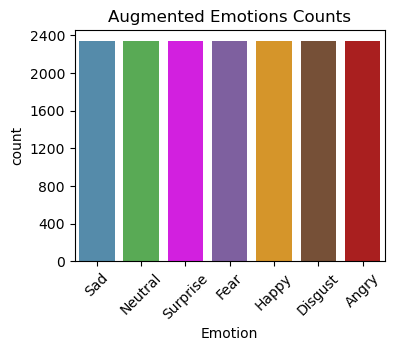

In [98]:
# Check that augmented dataset is in fact balanced
plt.figure(figsize=(4,3))
plt.title('Augmented Emotions Counts')
emotions=sns.countplot(x='Emotion',data=train,palette=colors)
emotions.set_xticklabels(emotions.get_xticklabels(),rotation=45)
y_tick_max = round(emotions.patches[0].get_height()/1000)*1000
emotions.yaxis.set_major_locator(ticker.MultipleLocator(y_tick_max/5))

In [99]:
# check info() on augmented dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16366 entries, 0 to 16365
Columns: 4591 entries, 0 to Emotion
dtypes: float64(4590), object(1)
memory usage: 573.2+ MB


In [100]:
#Load one of the files to show how the augmentations work
ex_emotion_type = "Happy"
ex_aug_file_path = audio_path[ex_emotion_type]
data,sr=librosa.load(ex_aug_file_path)

<a id="4"></a>
## Check data Augmentation Behaviour
### Original Audio

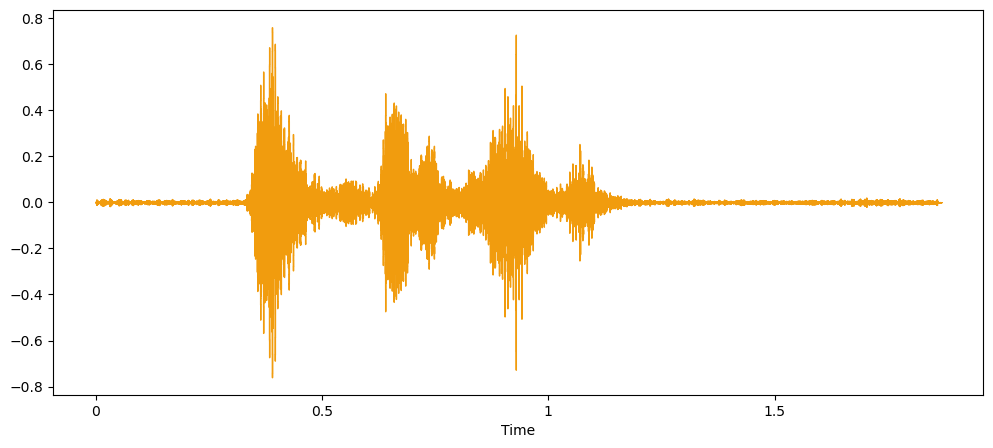

In [101]:
plt.figure(figsize=(12,5))
librosa.display.waveshow(data,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(ex_aug_file_path)

<a id="8"></a>
### Noised Audio

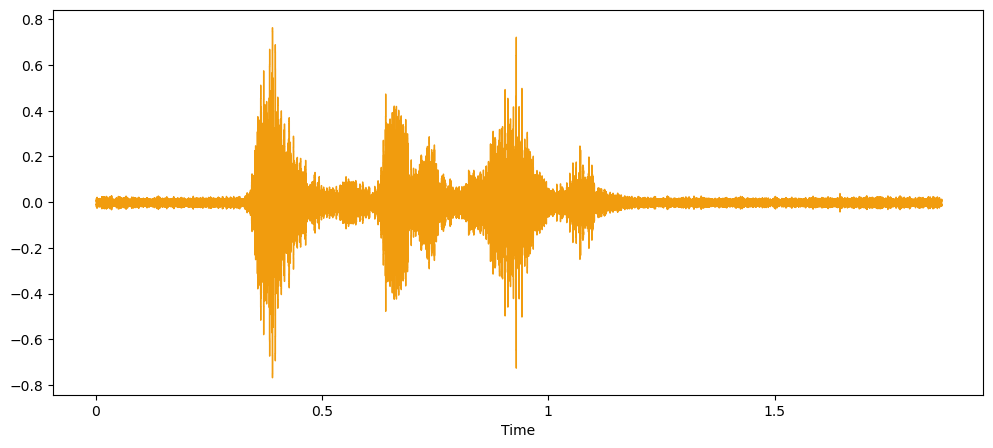

In [102]:
noised_audio=balancer.add_noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(noised_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(noised_audio,rate=sr)

<a id="10"></a>
### Stretched Audio

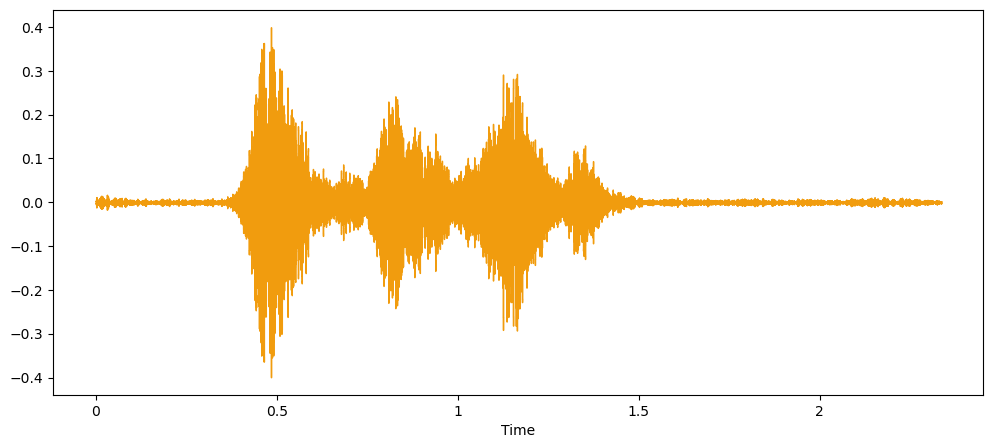

In [103]:
stretched_audio=balancer.streching(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(stretched_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(stretched_audio,rate=sr)

<a id="11"></a>
### Shifted Audio

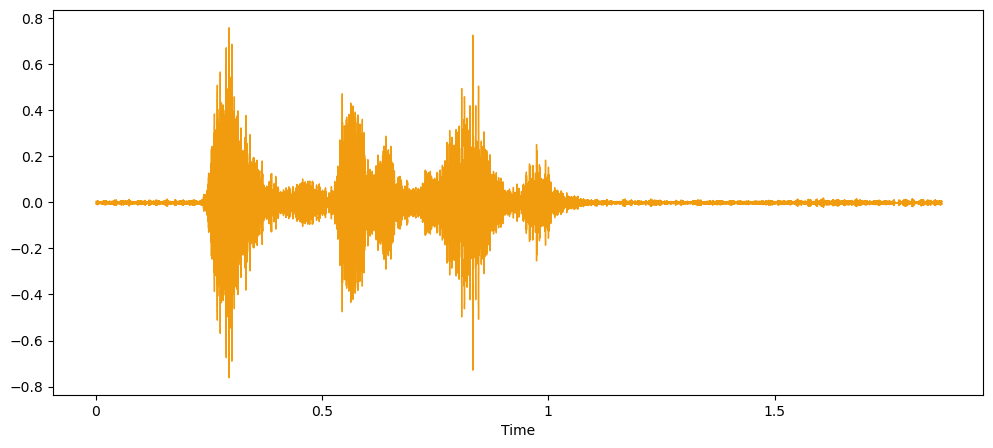

In [104]:
shifted_audio=balancer.shifting(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(shifted_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(shifted_audio,rate=sr)

<a id="12"></a>
### Pitched Audio

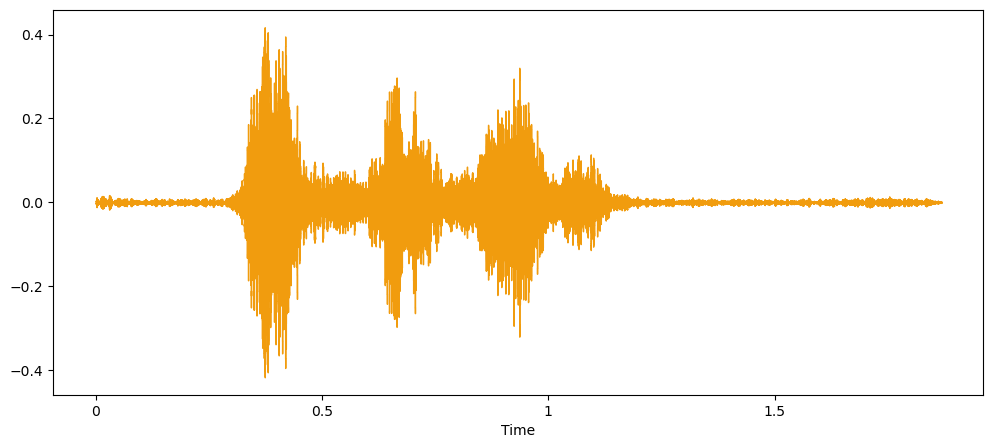

In [105]:
pitched_audio=balancer.pitching(data,sr)
plt.figure(figsize=(12,5))
librosa.display.waveshow(pitched_audio,sr=sr,color=colors[ex_emotion_type])
IPython.display.Audio(pitched_audio,rate=sr)

<a id="14"></a>
# Processing

<a id="15"></a>
### Including Analyzed Audio Features

In [191]:
df_train = pd.read_csv("train_data.csv")
df_val = pd.read_csv("val_data.csv")
df_test = pd.read_csv("test_data.csv")
features_train=pd.read_csv("train_features.csv")
features_val=pd.read_csv("val_features.csv")
features_test=pd.read_csv("test_features.csv")

feature_columns = ["Wave", "sr", "Augmentation", "Data Set"]
features_train.columns = feature_columns
features_val.columns = feature_columns
features_test.columns = feature_columns

X_train = df_train.drop(labels='Emotion',axis=1)
y_train = df_train['Emotion']

X_val = df_val.drop(labels='Emotion',axis=1)
y_val = df_val['Emotion']

X_test = df_test.drop(labels='Emotion',axis=1)
y_test = df_test['Emotion']

print(f"Train:\t X: {X_train.shape},\t y: {y_train.shape},\t features: {features_train.shape}")
print(f"Val:\t X: {X_val.shape},\t y: {y_val.shape},\t features: {features_val.shape}")
print(f"Test:\t X: {X_test.shape},\t y: {y_test.shape},\t features: {features_test.shape}")

Train:	 X: (16366, 4590),	 y: (16366,),	 features: (16366, 4)
Val:	 X: (1218, 4590),	 y: (1218,),	 features: (1218, 4)
Test:	 X: (1358, 4590),	 y: (1358,),	 features: (1358, 4)


In [164]:
X_train=X_train.fillna(0)
X_val=X_val.fillna(0)
X_test=X_test.fillna(0)
print(f"No NA values: {not(X_train.isna().any().any() and X_val.isna().any().any() and  X_test.isna().any().any())}")

No NA values: True


<a id="16"></a>
# Processing Analyzed Data for Training

In [165]:
# Convert emotion label to an index
indexes = {'Disgust':0,'Happy':1,'Sad':2,'Neutral':3,'Fear':4,'Angry':5,'Surprise':6}

# Convert the labels into a catagorical columns and a torch tensor
y_train = torch.tensor(y_train.map(indexes))
y_val = torch.tensor(y_val.map(indexes))
y_test = torch.tensor(y_test.map(indexes))

# Encode the data
lb=LabelEncoder()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

# Perform One Hot encoding on the labels
y_train = torch.nn.functional.one_hot(torch.tensor(y_train)).float()
y_val = torch.nn.functional.one_hot(torch.tensor(y_val)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test)).float()


In [166]:
y_train

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

## Normalize the data using Standard Scaler

In [167]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((16366, 4590),
 (1358, 4590),
 (1218, 4590),
 torch.Size([16366, 7]),
 torch.Size([1358, 7]),
 torch.Size([1218, 7]))

In [168]:
X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((16366, 4590, 1), (1358, 4590, 1), (1218, 4590, 1))

<a id="19"></a>
# Train the model

## Setup Pytorch Neural Network

In [169]:
# Define the Convolutional Neural Network to train the model with in a class
class AudioModel(nn.Module):
    def __init__(self):
        super(AudioModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(512)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv3 = nn.Conv1d(in_channels=512, out_channels=256, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(kernel_size=5, stride=2, padding=2)
        
        self.conv5 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(128)
        self.pool5 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(in_features=128*144, out_features=512)
        self.bn6 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(in_features=512, out_features=7)
        
    def forward(self, x):
        x = self.pool1(self.bn1(F.relu(self.conv1(x))))
        x = self.pool2(self.bn2(F.relu(self.conv2(x))))
        x = self.pool3(self.bn3(F.relu(self.conv3(x))))
        x = self.pool4(self.bn4(F.relu(self.conv4(x))))
        x = self.pool5(self.bn5(F.relu(self.conv5(x))))
        x = x.flatten(start_dim=1)
        x = self.bn6(nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        x = nn.functional.softmax(x, dim=1)
        return x

audio_model = AudioModel()
audio_model

AudioModel(
  (conv1): Conv1d(1, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv2): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv3): Conv1d(512, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=F

<a id="18"></a>
## Tuning for Training

In [170]:
#Define an early stopper class to use during training

class EarlyStopper():
    def __init__(self, patience: int = 3):
        self.best_val = +np.inf
        self.current_val = +np.inf
        self.patience = patience
        self.steps_since_last_best = 0
        
    def __call__(self, val) -> bool:
        self.current_val = val
        self._update_best()
        if self.steps_since_last_best == self.patience:
            return True
        else:
            return False
        
    def _update_best(self):
        if self.current_val < self.best_val:
            tqdm.write(f"New best: {self.current_val:.4f}")
            self.best_val=self.current_val
            self.steps_since_last_best = 0
        else:
            self.steps_since_last_best+=1

# Pick an optimizer and use it to define a scheduler
optim = torch.optim.Adam(params=audio_model.parameters())

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    "min",
    factor=0.1,
    patience=2,
    verbose=True
)

### Initialize a dataloader and create dataloaders for train, test, split

In [171]:
def get_data_loader(x,y,bs):
    # Permute np.array from NLC TO NCL
    x = torch.permute(torch.Tensor(x), dims=(0, 2, 1))
    y = torch.Tensor(y)
    return DataLoader(
        TensorDataset(x, y),
        batch_size=bs,
    )

# Check the device and set datasize accordingly
if device == "cpu":
    # Small dataset for cpu running to setup data
    length = 100
    train_loader = get_data_loader(X_train[:length, :], y_train[:length, :], 8)
    val_loader = get_data_loader(X_val[:length, :], y_val[:length, :], 8)
    test_loader = get_data_loader(X_test[:length, :], y_test[:length, :], 8)
else:
    # Run full datasets on GPU for final training
    train_loader = get_data_loader(X_train, y_train, 8)
    val_loader = get_data_loader(X_val, y_val, 8)
    test_loader = get_data_loader(X_test, y_test, 8)

### Define functions for training and validating the model

In [174]:
# New code to define a model trainer
def train(model, optim, scheduler, criterion, train_loader) -> tuple([float, float]):
    device = next(iter(model.parameters())).device
    model.train()
    total_loss = 0
    total_acc = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        total_loss += loss.item()
        total_acc += torch.sum(torch.argmax(y_pred.squeeze(), dim=1) == torch.argmax(y)).item()
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / (len(train_loader.dataset))
    scheduler.step(avg_loss)
    return avg_loss, avg_acc

@torch.no_grad()
def validate(model, val_loader, criterion) -> tuple([float, float]):
    model.eval()
    device = next(iter(audio_model.parameters())).device
    total_loss = 0
    total_acc = 0
    for x,y in val_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y)
        total_loss+=loss.item()
        total_acc+=torch.sum(torch.argmax(y_pred.squeeze(), dim=1) ==  torch.argmax(y)).item()
    avg_loss = total_loss / len(val_loader)
    avg_acc = total_acc / (len(val_loader.dataset))
    return avg_loss, avg_acc


### Train the model

In [175]:
model_name = "./best_model_balanced.pt" # Path to save best model
epochs = 100 if device == "cuda" else 3 # Number of epochs to run
criterion = nn.CrossEntropyLoss() # Criteria to evaluate performance
early_stopper = EarlyStopper(patience=10)
audio_model.to(device)
train_val_loss_acc_hist_avgs = {"epoch":[], "train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}
# Loop over the epochs, train the model, and check if the error is improving
for _ in tqdm(range(epochs)):
    train_loss, train_acc = train(audio_model, optim, lr_scheduler, criterion, train_loader)
    val_loss, val_acc = validate(audio_model, val_loader, criterion)
    train_val_loss_acc_hist_avgs["epoch"].append(_)
    train_val_loss_acc_hist_avgs["train_loss"].append(train_loss)
    train_val_loss_acc_hist_avgs["val_loss"].append(val_loss)
    train_val_loss_acc_hist_avgs["train_acc"].append(train_acc)
    train_val_loss_acc_hist_avgs["val_acc"].append(val_acc)
    if early_stopper(val_loss):
        break
    if early_stopper.steps_since_last_best == 0:
        torch.save(audio_model, model_name)

 33%|███▎      | 1/3 [00:48<01:36, 48.12s/it]

New best: 2.0594


100%|██████████| 3/3 [02:16<00:00, 45.63s/it]


# Reload Best Model and Evaluate Performance

In [176]:
net = torch.load(model_name)
net.eval() # Set the model to evaluation mode prior to testing

AudioModel(
  (conv1): Conv1d(1, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv2): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv3): Conv1d(512, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=5, stride=2, padding=2, dilation=1, ceil_mode=F

In [177]:
# Calculate how many items it gets right
correct = 0
total = 0

cm_labels = np.array([])
cm_pred = np.array([])

with torch.no_grad():
    for audio, labels in test_loader:

        # Convert if run on a cuda device
        if device != "cpu":
            audio = audio.cuda()
            labels = labels.cuda()

        # Predict the outputs
        outputs = net(audio)
        _, labels = torch.max(labels.data, 1)
        _, predicted = torch.max(outputs.data, 1)

        # Count the number of outputs gottten correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Add the label and prediction to build a confusion matrix later
        cm_labels = np.concatenate([cm_labels, labels.cpu().numpy()], axis = 0)
        cm_pred = np.concatenate([cm_pred, predicted.cpu().numpy()], axis = 0)

print(f'Accuracy of the network on the test audio samples: {100 * correct / total:.2f}: %')

Accuracy of the network on the test audio samples: 11.00: %


<a id="20"></a>
# Analyze The Model Performance

<a id="21"></a>
## Accuracy History Charts

   epoch  train_loss  val_loss  train_acc  val_acc
0      0    1.840839  2.059417       0.19     0.22
1      1    1.799327  2.107730       0.15     0.16
2      2    1.703997  2.107730       0.20     0.16
   epoch  train_loss  val_loss  train_acc  val_acc
0      0    1.840839  2.059417       0.19     0.22
1      1    1.799327  2.107730       0.15     0.16
2      2    1.703997  2.107730       0.20     0.16


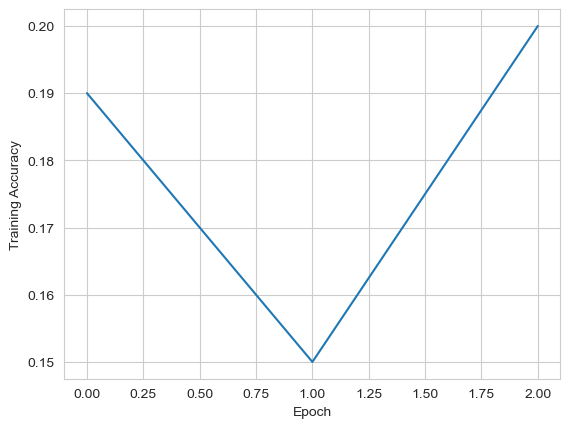

In [178]:
# create dataframe from the history
df = pd.DataFrame.from_dict(train_val_loss_acc_hist_avgs)
print(df.head())
print(df.tail())

# plot Training Accuracy Data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='train_acc', label='Training Accuracy', legend=False)

# labels
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.show()

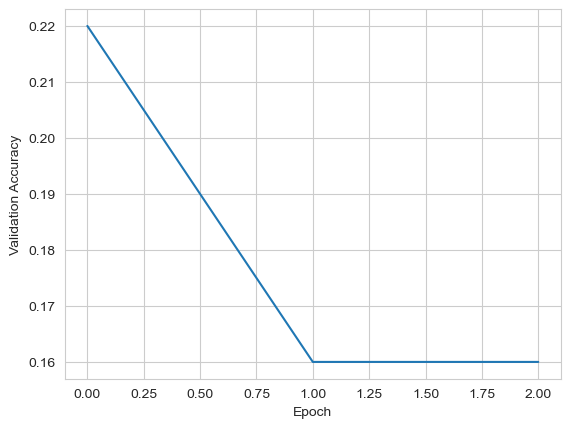

In [179]:
# plot the Validation Accuracy data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='val_acc', label='Validation Accuracy', legend=False)

# labels
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

<a id="22"></a>
## Loss History Charts

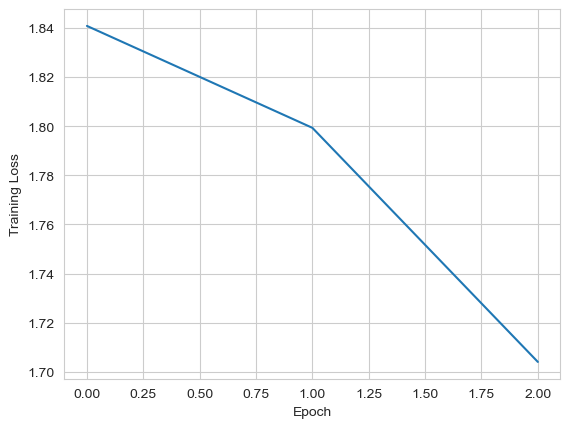

In [180]:
# create dataframe from the history
df = pd.DataFrame.from_dict(train_val_loss_acc_hist_avgs)
# plot the Training Loss data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='train_loss', label='Training Loss', legend=False)

# labels
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

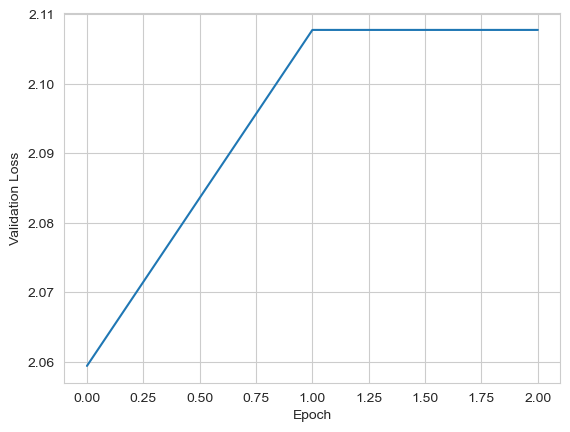

In [181]:
# plot the Validation Loss data
sns.set_style('whitegrid')
sns.lineplot(data=df, x='epoch', y='val_loss', label='Validation Loss', legend=False)

# labels
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

<a id="24"></a>
# Testing Model and Test Results

<a id="25"></a>
## Confusion Matrix

['Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Angry' 'Surprise']
[[ 0  0  4  0  0  0 10]
 [ 0  0  0  0  0  0 14]
 [ 0  0  4  0  0  0 14]
 [ 0  0  1  0  0  0 10]
 [ 0  0  3  0  0  0 19]
 [ 0  0  0  0  0  0 11]
 [ 0  0  3  0  0  0  7]]


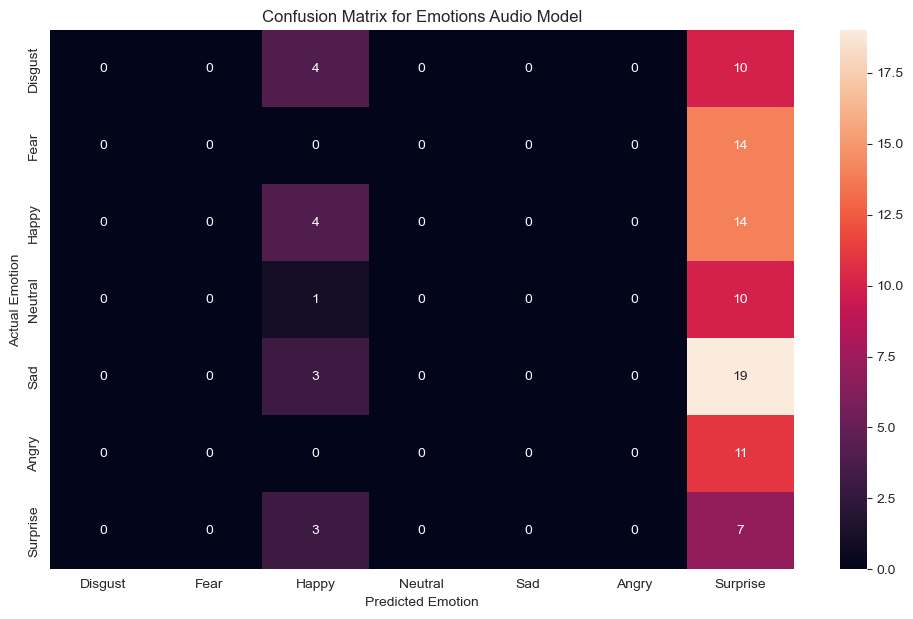

In [182]:
print(emotion_names)

conf=confusion_matrix(y_true=cm_labels,y_pred=cm_pred)
print(conf)

cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')

ax.set_title(f'Confusion Matrix for Emotions Audio Model')
ax.set_xlabel("Predicted Emotion")
ax.set_ylabel("Actual Emotion")
plt.show()

In [183]:
cr = classification_report(y_true=cm_labels, y_pred=cm_pred, target_names=emotion_names)
print("Classification Report:\n", cr)

Classification Report:
               precision    recall  f1-score   support

     Disgust       0.00      0.00      0.00        14
        Fear       0.00      0.00      0.00        14
       Happy       0.27      0.22      0.24        18
     Neutral       0.00      0.00      0.00        11
         Sad       0.00      0.00      0.00        22
       Angry       0.00      0.00      0.00        11
    Surprise       0.08      0.70      0.15        10

    accuracy                           0.11       100
   macro avg       0.05      0.13      0.06       100
weighted avg       0.06      0.11      0.06       100



## Evaluate Misclassifications

In [184]:
# We don't train on raw audio files just features. So it is easier to just reload a batch and look for errors

batch_size = 8
samples = main_df.sample(batch_size)

# Apply same data manipulations
loader = AudioLoader()
X_post, Y_post, _ = loader.load(samples, "")
X_post = pd.DataFrame(X_post)
X_post = X_post.reindex(columns=range(X_train.shape[1]), fill_value=0)
X_post = X_post.fillna(0)
X_post = scaler.transform(X_post)
X_post = np.expand_dims(X_post,axis=2)
Y_post = pd.DataFrame(Y_post)[0].map(indexes)

Loading data...


100%|██████████| 8/8 [00:00<00:00, 19.22it/s]


In [185]:
#Make a prediction based on the data rows pulled with known audio
x = torch.permute(torch.Tensor(X_post), dims=(0, 2, 1))
labels= torch.Tensor(Y_post)

if device == "cuda":
    x = x.cuda()
    labels = labels.cuda()

predictions = net(x)
_, predictions = torch.max(predictions.data, 1)
missclassifications = torch.nonzero(predictions != labels, as_tuple=False)[:, 0].tolist()
missclassifications

[0, 1, 2, 3, 4, 5, 6, 7]

## Listen to some missclassications

In [186]:
i = missclassifications[0]
print(f"Actual Label: {emotion_names[int(labels[i].item())]}, Model Prediction {emotion_names[int(predictions[i].item())]}")
data,sr=librosa.load(samples.iloc[i].File_Path)
IPython.display.Audio(data, rate=sr)

Actual Label: Angry, Model Prediction Surprise


In [187]:
i = missclassifications[1]
print(f"Actual Label: {emotion_names[int(labels[i].item())]}, Model Prediction {emotion_names[int(predictions[i].item())]}")
data,sr=librosa.load(samples.iloc[i].File_Path)
IPython.display.Audio(data, rate=sr)

Actual Label: Sad, Model Prediction Surprise


In [188]:
i = missclassifications[2]
print(f"Actual Label: {emotion_names[int(labels[i].item())]}, Model Prediction {emotion_names[int(predictions[i].item())]}")
data,sr=librosa.load(samples.iloc[i].File_Path)
IPython.display.Audio(data, rate=sr)

Actual Label: Fear, Model Prediction Happy


## Error Distribution of Augmentations

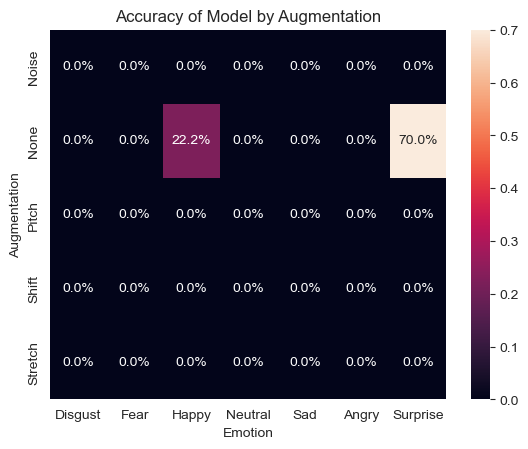

In [192]:
# cm_labels = np.array([])
# cm_pred = np.array([])
cm_augmentation = features_test["Augmentation"].to_numpy()

df_features = pd.DataFrame()
df_features["label"] = cm_labels
df_features["prediction"] = cm_pred
df_features["augmentation"] = cm_augmentation[:len(cm_labels)]
df_features.head()

cl = []

for aug in np.unique(cm_augmentation):
	subset = []
	for emotion in np.unique(cm_labels):
		correct = df_features[df_features["label"] == emotion][df_features["label"] == df_features["prediction"]][df_features["augmentation"] == aug][df_features["label"] == df_features["prediction"]].shape[0]
		total = df_features[df_features["label"] == emotion][df_features["augmentation"] == aug].shape[0]
		subset.append(correct/total if total != 0 else 0)
	cl.append(subset)

cl_df = pd.DataFrame(cl, np.unique(cm_augmentation), columns=[i for i in emotion_names])

ax=sns.heatmap(cl_df,annot=True,fmt='.1%')
ax.set_title(f'Accuracy of Model by Augmentation')
ax.set_xlabel("Emotion")
ax.set_ylabel("Augmentation")
plt.show()


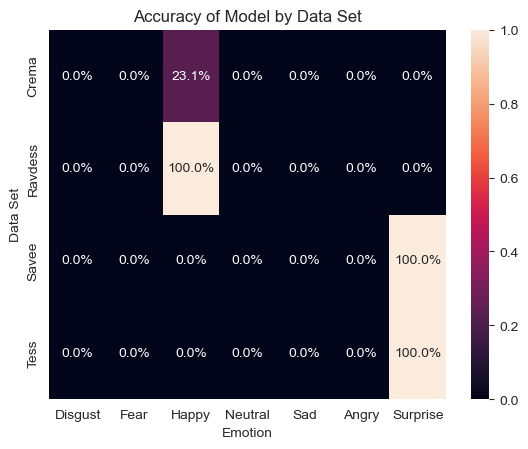

In [194]:
# cm_labels = np.array([])
# cm_pred = np.array([])
cm_augmentation = features_test["Data Set"].to_numpy()

df_features = pd.DataFrame()
df_features["label"] = cm_labels
df_features["prediction"] = cm_pred
df_features["data set"] = cm_augmentation[:len(cm_labels)]
df_features.head()

cl = []

for aug in np.unique(cm_augmentation):
	subset = []
	for emotion in np.unique(cm_labels):
		correct = df_features[df_features["label"] == emotion][df_features["label"] == df_features["prediction"]][df_features["data set"] == aug][df_features["label"] == df_features["prediction"]].shape[0]
		total = df_features[df_features["label"] == emotion][df_features["data set"] == aug].shape[0]
		subset.append(correct/total if total != 0 else 0)
	cl.append(subset)

cl_df = pd.DataFrame(cl, np.unique(cm_augmentation), columns=[i for i in emotion_names])

ax=sns.heatmap(cl_df,annot=True,fmt='.1%')
ax.set_title(f'Accuracy of Model by Data Set')
ax.set_xlabel("Emotion")
ax.set_ylabel("Data Set")
plt.show()

# Live Data Demo

In [ ]:
import sounddevice as sd
import soundfile as sf
import numpy as np
import time

fs = 16000 
seconds = 3  
path="test.wav"
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  
sf.write(path, myrecording, fs)  

sd.play(myrecording, fs)
time.sleep(seconds)
sd.stop()

audio_loader = AudioLoader()
data,sr=librosa.load(path,duration=2.5, offset=0.6)
aud=audio_loader.extract_features(data,sr)
audio=np.array(aud)

model = torch.load(model_name)

enmoji={'Disgust':'😷','Happy':'😃','Sad':'😢','Neutral':'😐','Fear':'😨','Angry':'😠','Surprise':'😲'}

with torch.no_grad():
    audio = torch.from_numpy(audio).float().to(device)
    outputs = model(audio)
    _, labels = torch.max(labels.data, 1)
    _, predicted = torch.max(outputs.data, 1)
    print(f'Predicted Emotion: {emotion_names[predicted]} {enmoji[emotion_names[predicted]]}')

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [3536]